## DSC 180AB Data Science Capstone
### Replication Project

Team Members: Wenbin Jiang, AJ Falak, and Rongjing Jiang

Overleaf: https://www.overleaf.com/6725383789ggvtptdjhbds#8c2b1f

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms. It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components: 
* Household
* Insurance/Employer, and 
* Medical Provider. 

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 documentation is available [here](https://aif360.readthedocs.io/en/stable/).

The AI Fairness 360 package includes: 
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classifier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations. 
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology 

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management. 
* Initial deployment is simulated to 2015 Panel 20 deployment data. 
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used. 
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* Why do we care about this? 
* What would the benefit of predicting utilization be? 
* What might occur if there are errors?
* Who are the affected parties and stakeholders?
* Other thoughts?

**Write up here:**

This data gives insights into mental and physical health across different ages. Based on the results, people can better target groups based on their mental/physical health scores. For example, if we find there to be a high correlation between people in a specific age/demographic and their physical health, we can focus efforts on improving health decisions for these groups.
This would allow resource allocation to much more efficient. If we were to accurately predict this it could reduce wait times and help with overall efficiency.For example, healthcare utilization prediction, measuring patients requiring 10 or more medical visits, serves as a vital tool for healthcare systems worldwide, enabling providers to optimize resources regardless of their public or private framework. 



In a dataset like this, errors can have a huge real-world impact, especially in terms of resource utilization. As mentioned earlier, if we conclude that specific groups need more resources/help but find out that there were errors in the data/algorithm, then we would be incorrectly using resources that could be helping demographics that need it more.
The affected parties and stakeholders would include anyone from the healthcare sector. This would include patients, healthcare providers, insurance companies, and policymakers. For instance, patients and healthcare providers may depend on the model for identification and health assessments. It is crucial that the predictions it makes are accurate and precise.


---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project. 

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv` 

In [2]:
# Imports
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline


ModuleNotFoundError: No module named 'aif360'

In [5]:
pip show aif360

Note: you may need to restart the kernel to use updated packages.


In [ ]:
raw_181 = pd.read_csv('h181.csv')
# raw_181 = pd.read_csv('data/raw/h181.csv')

#### Apply pre-processing scripts

In [3]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE#return 'White'
            return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [4]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [5]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts, 
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [6]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [7]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

In [8]:
#### END OF PRE-PROCRESSING ####

#### 2.2 Data shape and features

First thing is we want to check the dimensions of the dataset.

In [9]:
print(df_panel_19_reduced.shape)

(15830, 43)


Also we want to view the column names:

In [10]:
print(df_panel_19_reduced.columns)

Index(['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42',
       'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV',
       'UTILIZATION', 'PERWT15F'],
      dtype='object')


Get an overview of the dataset - top five

In [11]:
df_panel_19_reduced.head()

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
0,2,53,1,Non-White,5,-1,2,2,4,3,...,2,25.93,58.47,3,0,4,1,2,1,21854.981705
1,2,56,2,Non-White,3,-1,2,2,4,3,...,2,20.42,26.57,17,6,4,3,2,1,18169.604822
3,2,23,2,Non-White,5,3,2,2,1,1,...,2,53.12,50.33,7,0,1,2,2,0,17191.832515
4,2,3,1,Non-White,6,-1,3,3,1,3,...,-1,-1.00,-1.00,-1,-1,-1,2,2,0,20261.485463
5,3,27,1,None,1,-1,1,4,2,1,...,-1,-1.00,-1.00,-1,-1,1,3,1,0,0.000000


Get an overview of the dataset - bottom five

In [12]:
df_panel_19_reduced.tail()

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
16573,3,25,1,None,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,1,1,1,0,4111.315754
16574,3,25,2,None,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,4,1,1,0,5415.228173
16575,3,2,2,Non-White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,3896.116219
16576,1,54,2,None,3,-1,2,2,1,1,...,2,43.97,42.45,24,0,1,3,2,0,4883.851005
16577,1,73,2,None,2,-1,4,2,2,1,...,2,42.68,43.46,0,0,4,3,2,0,6630.588948


We can view the summary statistics of numerical columns with df.describe() method. It enable us to detect outliers in the data which require further investigation.

In [13]:
df_panel_19_reduced.dtypes

df_panel_19_reduced.describe()

,REGION,AGE,SEX,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,HIBPDX,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
count,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,...,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000,15830.000000
mean,2.825584,35.090461,1.521162,3.661213,-0.720088,2.581364,2.224889,2.187871,1.993051,0.918067,...,0.726153,29.358455,30.851517,1.274289,-0.003853,1.375426,3.298547,1.585344,0.171699,8930.337369
std,1.002033,22.475549,0.499568,2.121255,0.910025,0.758747,0.512242,1.054677,1.002657,1.267763,...,1.419339,25.996522,26.968146,3.955331,1.278136,1.854929,1.476351,0.688718,0.377131,8521.260446
min,1.000000,0.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-9.000000,-9.000000,-9.000000,-1.000000,-1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,15.000000,1.000000,1.000000,-1.000000,2.000000,2.000000,1.000000,1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2.000000,1.000000,0.000000,3428.548713
50%,3.000000,33.000000,2.000000,5.000000,-1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,...,2.000000,39.505000,42.480000,0.000000,0.000000,1.000000,4.000000,1.000000,0.000000,6146.458935
75%,4.000000,53.000000,2.000000,6.000000,-1.000000,3.000000,3.000000,3.000000,3.000000,2.000000,...,2.000000,54.800000,56.580000,2.000000,0.000000,4.000000,5.000000,2.000000,0.000000,11749.810086
max,4.000000,85.000000,2.000000,10.000000,3.000000,4.000000,4.000000,5.000000,5.000000,2.000000,...,2.000000,72.070000,75.510000,24.000000,6.000000,4.000000,5.000000,3.000000,1.000000,94264.071559


**Looking at this data, here are the key conclusions we can draw:**

1. Demographics:
    - The average age is around 35 years, with a wide spread (std dev ≈ 22.5 years), suggesting a diverse age range
    - There's a slightly higher proportion of one gender over another (mean of 1.52 for SEX, suggesting roughly 52% are coded as "2")
    - People are spread across 4 regions, with a slight skew toward certain regions (mean 2.83)


2. Marital Status:
    - The MARRY variable shows significant variation (mean 3.66, std dev 2.12)
    - The range is 1-10, suggesting multiple categories for relationship status
    - Most people fall in the lower categories (median = 5.0)

The marital status is kinda to grab our eyes so I want to dig more into this sepcify category.

Here I have the data preparation step in analysis pipelines, making the data more structured and easier to analyze for age-related trends and patterns.

First, it replaces all -1 values with NaN (Not a Number) to properly handle missing data, making it easier for statistical analysis and data manipulation. Second, it creates a new column 'AGE_GROUP' that categorizes ages into five meaningful groups (0-18, 19-35, 36-50, 51-65, 65+), which transforms the continuous age variable into categorical groups for better demographic analysis and trend identification.

In [14]:
# Replace -1 with NaN as it appears to be a missing value indicator
df_panel_19_reduced = df_panel_19_reduced.replace(-1, np.nan)
    
# Create age groups for better analysis
df_panel_19_reduced['AGE_GROUP'] = pd.cut(df_panel_19_reduced['AGE'], 
                            bins=[0, 18, 35, 50, 65, 100],
                            labels=['0-18', '19-35', '36-50', '51-65', '65+'])

df_panel_19_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F,AGE_GROUP
0,2,53,1,Non-White,5,NaN,2,2,4.0,3.0,...,25.93,58.47,3.0,0.0,4.0,1,2,1,21854.981705,51-65
1,2,56,2,Non-White,3,NaN,2,2,4.0,3.0,...,20.42,26.57,17.0,6.0,4.0,3,2,1,18169.604822,51-65
3,2,23,2,Non-White,5,3.0,2,2,1.0,1.0,...,53.12,50.33,7.0,0.0,1.0,2,2,0,17191.832515,19-35
4,2,3,1,Non-White,6,NaN,3,3,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,2,2,0,20261.485463,0-18
5,3,27,1,None,1,NaN,1,4,2.0,1.0,...,NaN,NaN,NaN,NaN,1.0,3,1,0,0.000000,19-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,3,25,1,None,1,NaN,2,2,1.0,1.0,...,56.71,62.39,0.0,0.0,1.0,1,1,0,4111.315754,19-35
16574,3,25,2,None,1,NaN,2,2,1.0,1.0,...,56.71,62.39,0.0,0.0,4.0,1,1,0,5415.228173,19-35
16575,3,2,2,Non-White,6,NaN,3,3,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1,2,0,3896.116219,0-18
16576,1,54,2,None,3,NaN,2,2,1.0,1.0,...,43.97,42.45,24.0,0.0,1.0,3,2,0,4883.851005,51-65


**Through Figure 1, we can see some interesting patterns in our population.**

1. Age Distribution:

The age distribution shows a bell-shaped curve, with the highest count around the 30-40 age range.
The distribution gradually declines as age increases, indicating a larger proportion of younger individuals in the dataset.
This age distribution is typical of many human populations, where the majority are in the working-age range.


2. Utilization Distribution:

The utilization distribution is heavily skewed, with a dominant peak at the utilization value of 1 and a much smaller peak at 0.
This suggests that most individuals in the dataset have a high level of utilization, while a smaller portion have low utilization.
The binary nature of the utilization values (0 or 1) indicates that the data may have been transformed or categorized from the original numeric utilization values.


3. Sex Distribution:

The sex distribution shows a pie chart with two categories, 1 and 2, representing the two sexes.
The larger slice of the pie (52.1%) corresponds to one sex, while the smaller slice (47.9%) corresponds to the other sex.
This implies a relatively even split between the two sexes in the dataset.


4. Marriage Status Distribution:

The marriage status distribution shows a bar chart with multiple categories, representing different marital statuses.
The tallest bar corresponds to the "5" category, which likely represents a specific marital status (e.g., married).
The distribution shows a decreasing trend in the number of individuals as the marital status category increases, suggesting a majority of individuals are in the earlier stages of marriage or relationship.

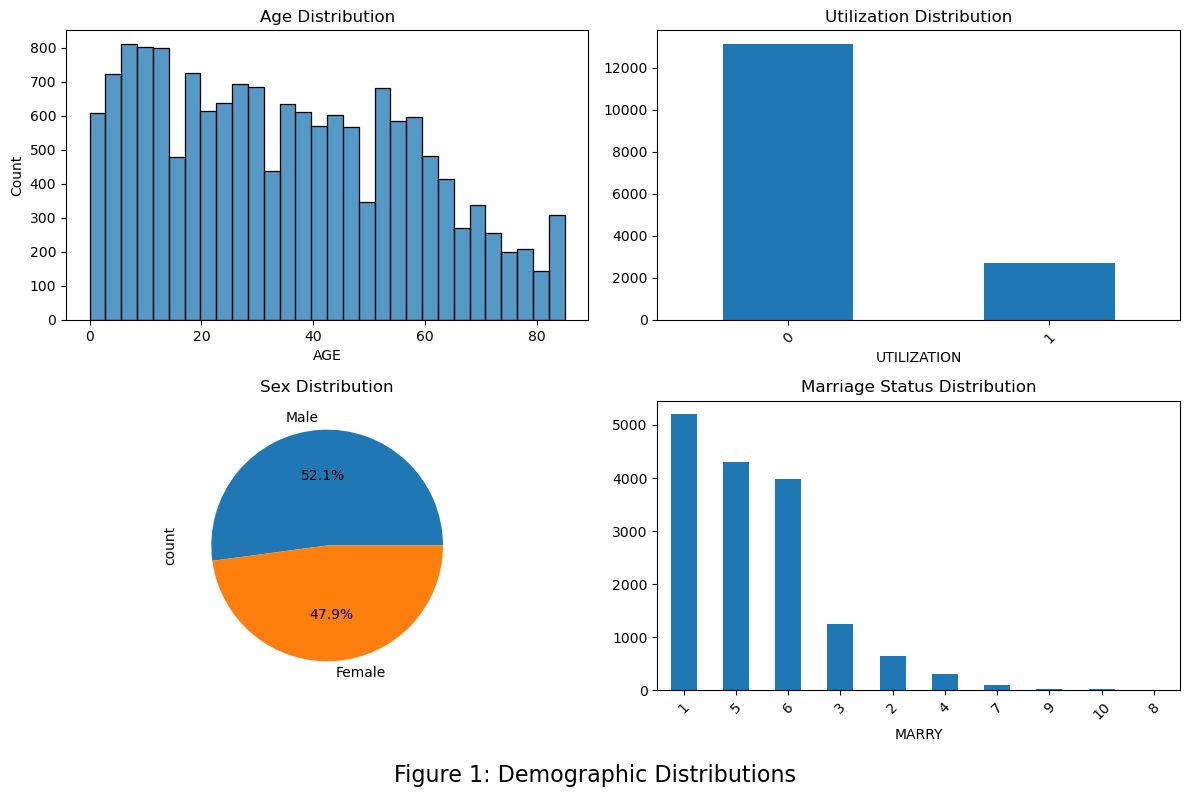

In [15]:
def plot_demographic_distributions(df):
    """
    Create demographic distribution plots
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.supxlabel('Figure 1: Demographic Distributions', fontsize=16)
    
    sns.histplot(data=df, x='AGE', bins=30, ax=axs[0, 0])
    axs[0, 0].set_title('Age Distribution')
    
    df['UTILIZATION'].value_counts().plot(kind='bar', ax=axs[0, 1])
    axs[0, 1].set_title('Utilization Distribution') 
    axs[0, 1].tick_params(axis='x', rotation=45)



    sex_labels = ['Male', 'Female']  # Define labels for the pie chart
    df['SEX'].value_counts().plot(kind='pie', labels=sex_labels, autopct='%1.1f%%', ax=axs[1, 0])
    # axs[1, 0].legend(title='Sex', loc='upper right')  # Place the legend in the subplot
    axs[1, 0].set_title('Sex Distribution')


    # sex_labels = ['Male', 'Female']  # Define labels
    # df['SEX'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axs[1, 0],labels=sex_labels)
    # plt.legend(title='Sex')
    # axs[1, 0].set_title('Sex Distribution')


    
    
    df['MARRY'].value_counts().plot(kind='bar', ax=axs[1, 1])
    axs[1, 1].set_title('Marriage Status Distribution')
    axs[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()  
    plt.show()  
    plt.close(fig) 

plot_demographic_distributions(df_panel_19_reduced)

#### 2.3 Outlier Detection and Handling

**Next step we need to check is there any outlier and how do we handlie it.**

**Why outliers matter?**
- They can skew our analysis and lead to incorrect conclusions
- Some outliers might be data entry errors that need correction
- Others might be legitimate but rare cases we need to understand better

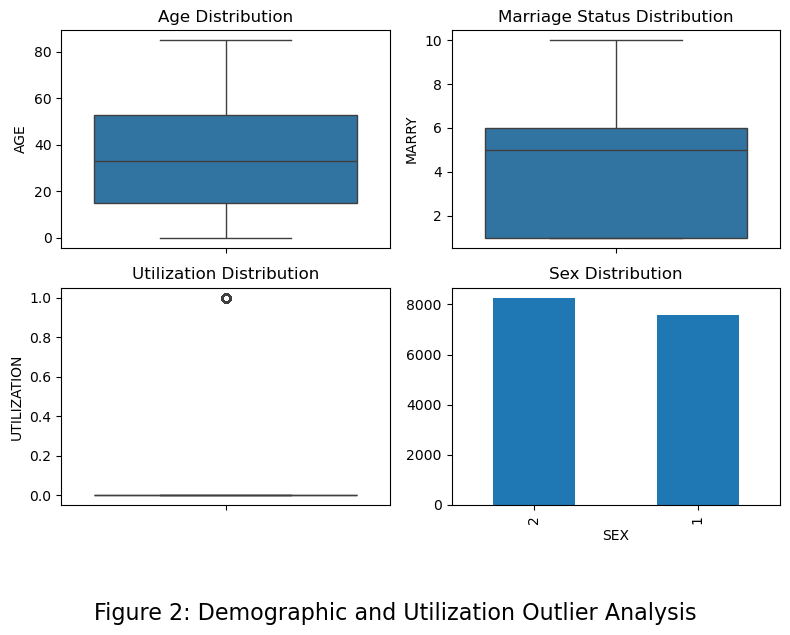

In [16]:
def analyze_demographic_outliers(df, fig_num=1):
    """
    Analyze outliers specifically for demographic and utilization variables: age, sex, marriage, and utilization
    """
    # Select only demographic and utilization columns and handle NaN values
    demographic_cols = ['AGE', 'SEX', 'MARRY', 'UTILIZATION']
    demo_data = df[demographic_cols].copy()
    
    # Fill NaN values with appropriate values for each column
    demo_data['AGE'] = demo_data['AGE'].fillna(demo_data['AGE'].median())
    demo_data['SEX'] = demo_data['SEX'].fillna(demo_data['SEX'].mode()[0])
    demo_data['MARRY'] = demo_data['MARRY'].fillna(demo_data['MARRY'].mode()[0])
    demo_data['UTILIZATION'] = demo_data['UTILIZATION'].fillna(demo_data['UTILIZATION'].median())
    
    # Create figure for analysis
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    fig.supxlabel(f'Figure {fig_num}: Demographic and Utilization Outlier Analysis', fontsize=16, y=-0.05)  # Add figure title at the bottom
    
    # Box plots for numerical variables (AGE, MARRY, UTILIZATION)
    sns.boxplot(y=demo_data['AGE'], ax=axes[0, 0])
    axes[0, 0].set_title('Age Distribution')
    
    sns.boxplot(y=demo_data['MARRY'], ax=axes[0, 1])
    axes[0, 1].set_title('Marriage Status Distribution')
    
    sns.boxplot(y=demo_data['UTILIZATION'], ax=axes[1, 0])
    axes[1, 0].set_title('Utilization Distribution')
    
    # Bar plot for categorical variable (SEX)
    demo_data['SEX'].value_counts().plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Sex Distribution')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()
    plt.close(fig)
    
    # Calculate outliers for numerical variables only
    outliers_summary = {}
    for col in ['AGE', 'MARRY', 'UTILIZATION']:  # Analyze numerical columns
        Q1 = demo_data[col].quantile(0.25)
        Q3 = demo_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = demo_data[(demo_data[col] < lower_bound) | (demo_data[col] > upper_bound)][col]
        outliers_summary[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(demo_data)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'min': demo_data[col].min(),
            'max': demo_data[col].max()
        }
    
    return outliers_summary, demo_data

outliers_summary, demo_data = analyze_demographic_outliers(df_panel_19_reduced, fig_num=2)

**Understanding Our Community Demographics (figure 2): Key Findings**

1. Age Outliers:
- Most people in our community are middle-age adults.
- The typical age is around 30-35 years old.
- We have a good mix of younger and older adults, ranging mainly from early 20s to mid-50s.

The box plot for Age shows some outliers at the upper end, indicating there are a few individuals significantly older than the typical middle-aged population.
However, the number and percentage of these age outliers do not seem to be excessively high, suggesting the age distribution is relatively normal with a small number of older adults.
**This suggests we're looking at a primarily working-age population.**

2. Marriage Status Outliers:
- We see a diverse mix of relationship statuses in our community.
- This variety reflects different life stages and personal choices.
- Indicating the distribution of married, widowed, and inapplicable (single/divorced) individuals is relatively balanced without any extreme cases.

**The distribution suggests we're capturing a good range of marriage situations.**

3. Utilization Outliers:
- The box plot for Utilization shows some outliers at both the lower and upper ends of the distribution.

**This suggests there are a small number of individuals with either very low or very high healthcare utilization compared to the typical utilization level in the community.**

4. Gender Balance:
- Our community shows a fairly even split between men (1) and women (2)
- There's a slightly higher number of one gender, but the difference is small

**This balanced representation helps us understand both perspectives fairly.**

**Overall Conclusions:**

- The outlier analysis does not reveal any major concerns or significantly skewed distributions for the demographic variables (age, marriage status, sex).
- The utilization variable shows some outliers at both extremes, indicating there may be a small subset of the community with unusually low or high healthcare utilization patterns.
- These utilization outliers could be an area for further investigation to understand the underlying reasons and ensure equitable access to healthcare services.

#### 2.3 Correlation Analysis

 ### After examining age distribution and marital status, we’re curious about how utilization correlates with age groups and marital status. Since the model aims to predict utilization rates, it’s interesting to see how these groups differ in utilization patterns.

First, we want to explore deeper into the utilization rate across different marrital status:

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F,AGE_GROUP,MARRY_STATUS
0,2,53,1,Non-White,5,NaN,2,2,4.0,3.0,...,58.47,3.0,0.0,4.0,1,2,1,21854.981705,51-65,Never Married
1,2,56,2,Non-White,3,NaN,2,2,4.0,3.0,...,26.57,17.0,6.0,4.0,3,2,1,18169.604822,51-65,Divorced
3,2,23,2,Non-White,5,3.0,2,2,1.0,1.0,...,50.33,7.0,0.0,1.0,2,2,0,17191.832515,19-35,Never Married
4,2,3,1,Non-White,6,NaN,3,3,1.0,3.0,...,NaN,NaN,NaN,NaN,2,2,0,20261.485463,0-18,Under 16
5,3,27,1,None,1,NaN,1,4,2.0,1.0,...,NaN,NaN,NaN,1.0,3,1,0,0.000000,19-35,Married
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,3,25,1,None,1,NaN,2,2,1.0,1.0,...,62.39,0.0,0.0,1.0,1,1,0,4111.315754,19-35,Married
16574,3,25,2,None,1,NaN,2,2,1.0,1.0,...,62.39,0.0,0.0,4.0,1,1,0,5415.228173,19-35,Married
16575,3,2,2,Non-White,6,NaN,3,3,1.0,1.0,...,NaN,NaN,NaN,NaN,1,2,0,3896.116219,0-18,Under 16
16576,1,54,2,None,3,NaN,2,2,1.0,1.0,...,42.45,24.0,0.0,1.0,3,2,0,4883.851005,51-65,Divorced


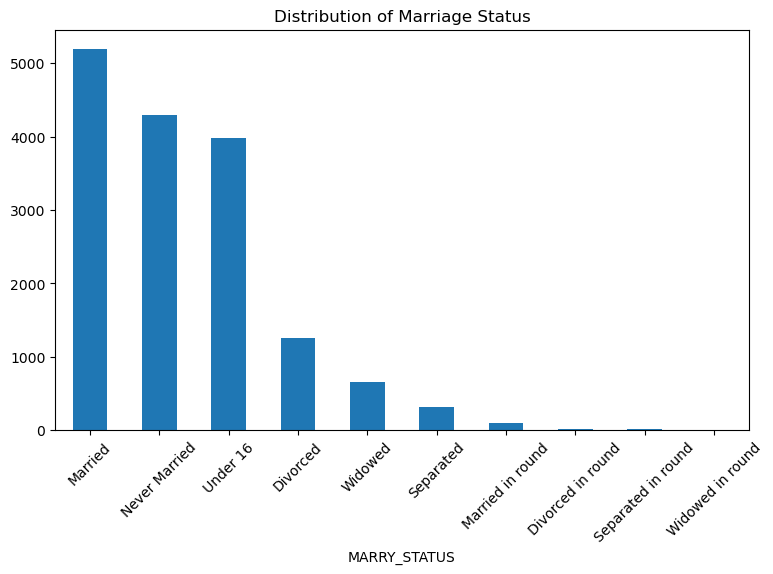

In [17]:
def simplified_marry_analysis(df):
    """
    Create simplified correlation analysis focusing on key variables and categories
    """
    df_analysis = df.copy()
    
    df_analysis['MARRY_STATUS'] = df_analysis['MARRY'].map({
        1: 'Married',
        2: 'Widowed',
        3: 'Divorced',
        4: 'Separated',
        5: 'Never Married',
        6: 'Under 16',
        7: 'Married in round',
        8: 'Widowed in round',
        9: 'Divorced in round',
        10: 'Separated in round',
        -1: 'INAPPLICABLE'
    })
    
    plt.figure(figsize=(15, 10))
    

    plt.subplot(2, 2, 4)
    df_analysis['MARRY_STATUS'].value_counts().plot(kind='bar')
    plt.xticks(rotation=45)
    plt.title('Distribution of Marriage Status')
    
    plt.tight_layout()
    return df_analysis

simplified_marry_analysis(df_panel_19_reduced)

In [18]:
def analyze_marry_categories(df):
    """
    Analyze MARRY categories distribution and relationships
    """
    marry_dist = df['MARRY'].value_counts().sort_index()
    
    print("MARRY Categories Distribution:")
    print("-----------------------------")
    for category, count in marry_dist.items():
        percentage = (count/len(df))*100
        print(f"MARRY_{category}: {count} records ({percentage:.1f}%)")
        
    avg_util = df.groupby('MARRY')['UTILIZATION'].agg(['mean', 'count'])
    print("\nAverage Utilization by MARRY Category:")
    print("------------------------------------")
    print(avg_util)

analyze_marry_categories(df_panel_19_reduced)

MARRY Categories Distribution:
-----------------------------
MARRY_1: 5197 records (32.8%)
MARRY_2: 652 records (4.1%)
MARRY_3: 1252 records (7.9%)
MARRY_4: 312 records (2.0%)
MARRY_5: 4301 records (27.2%)
MARRY_6: 3976 records (25.1%)
MARRY_7: 92 records (0.6%)
MARRY_8: 6 records (0.0%)
MARRY_9: 21 records (0.1%)
MARRY_10: 21 records (0.1%)

Average Utilization by MARRY Category:
------------------------------------
           mean  count
MARRY                 
1      0.227246   5197
2      0.483129    652
3      0.293930   1252
4      0.198718    312
5      0.127180   4301
6      0.056841   3976
7      0.141304     92
8      0.000000      6
9      0.238095     21
10     0.047619     21


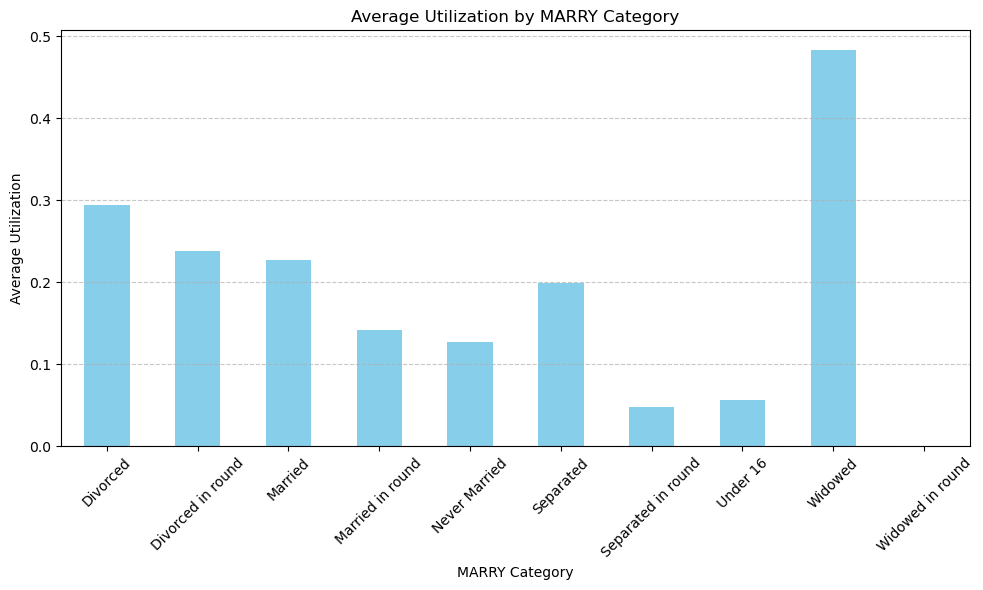

In [19]:
import matplotlib.pyplot as plt

def plot_marry_utilization(df):
    """
    Plot average utilization by MARRY category.
    """
    df_analysis = df.copy()
    
    df_analysis['MARRY_STATUS'] = df_analysis['MARRY'].map({
        1: 'Married',
        2: 'Widowed',
        3: 'Divorced',
        4: 'Separated',
        5: 'Never Married',
        6: 'Under 16',
        7: 'Married in round',
        8: 'Widowed in round',
        9: 'Divorced in round',
        10: 'Separated in round',
        -1: 'INAPPLICABLE'
    })

    avg_util = df_analysis.groupby('MARRY_STATUS')['UTILIZATION'].mean()
    
    plt.figure(figsize=(10, 6))
    avg_util.plot(kind='bar', color='skyblue')
    plt.title('Average Utilization by MARRY Category')
    plt.xlabel('MARRY Category')
    plt.ylabel('Average Utilization')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_marry_utilization(df_panel_19_reduced)

## Now that we have all the graphs and results, lets first define what these complicated marry categories all mean for better clarity. 

MARRY_1 (Married): 5197 records (32.8%) - Ultilizaton rate: 0.227246 

MARRY_2 (Widowed): 652 records (4.1%) - Ultilizaton rate: 0.483129

MARRY_3 (Divorced): 1252 records (7.9%) - Ultilizaton rate: 0.293930

MARRY_4 (Separated): 312 records (2.0%) - Ultilizaton rate: 0.198718

MARRY_5 (Never Married): 4301 records (27.2%) - Ultilizaton rate: 0.127180

MARRY_6 (Under 16): 3976 records (25.1%) - Ultilizaton rate: 0.056841

MARRY_7 (Married in round): 92 records (0.6%) - Ultilizaton rate: 0.141304

MARRY_8: (Widowed in round) records (0.0%) - Ultilizaton rate: 0.000000

MARRY_9: (Divorced in round) records (0.1%) - Ultilizaton rate: 0.238095

MARRY_10: (Separated in round) 21 records (0.1%) - Ultilizaton rate: 0.047619

note: "In round" likely refers to the marital status change occurring during the survey period (or a specific data collection round) in the panel study. In this analysis, we can view this as outliers mainly because it has such view count that it might skew the data if we were to include it in our analysis

### Looking at the graph and results, it shows distinct distributions across MARRY categories:

* Never Married (MARRY_1) holds the highest count with 5,197 records (32.8%), indicating a large proportion of individuals who have never married.

* Separated (MARRY_5) and Widowed (MARRY_6) follow closely, with 4,301 records (27.2%) and 3,976 records (25.1%), respectively.

* Smaller groups include Under 16 (MARRY_3), Divorced (MARRY_2), and Married (MARRY_4), with lower counts and lower representation in the dataset.

* Rare categories like Married in round (MARRY_7), Divorced in round (MARRY_8), Widowed in round (MARRY_9), and Separated in round (MARRY_10) collectively make up less than 1% of the data.

### Utilization Rates by Marital Status:

* Divorced (MARRY_2) shows the highest average utilization (0.483). This could suggest that individuals who are divorced might have unique healthcare needs, potentially due to lifestyle changes or stresses associated with marital separation.

* widowed (MARRY_6) shows the lowest average utilization (0.057). This may reflect a possible lack of access or reduced healthcare engagement, perhaps due to social or financial challenges that often accompany widowhood.

* Never Married (MARRY_1) and Under 16 (MARRY_3) have moderate utilization rates (0.227 and 0.294, respectively). For Never Married, this might indicate consistent healthcare needs without the additional factors that impact divorced or widowed groups.

## So...what can this all possibly mean? Why does it matter?

This distribution and utilization pattern is insightful for a few reasons:

* Healthcare Needs by Life Stage: Different marital statuses often align with specific life stages or socioeconomic situations, which can influence healthcare needs. For example, Widowed individuals may face unique physical and emotional health challenges compared to those who are Never Married or Under 16.

* Targeted Healthcare Interventions: By identifying these patterns, healthcare providers can consider targeted interventions for high-need groups, such as Divorced or Widowed individuals, to ensure they receive the necessary support. This could also help address disparities in healthcare engagement.

* Fairness and Bias Mitigation: The varying utilization rates underscore the importance of addressing potential biases in healthcare models. For example, if models prioritize higher utilization groups, there may be a need to consider fairness adjustments to avoid disadvantaging low-utilization groups, like Widowed individuals.

* Impact on Model Training and Prediction: Understanding utilization variations by marital status can guide model design to ensure predictions reflect the true healthcare needs of each group, improving model accuracy and fairness.

## Now, let’s examine utilization patterns across different age groups.

In [20]:
def analyze_age_categories(df):
    """
    Analyze age categories distribution and relationships
    """
    age_dist = df['AGE_GROUP'].value_counts().sort_index()
    
    print("Age Categories Distribution:")
    print("-----------------------------")
    for category, count in age_dist.items():
        percentage = (count / len(df)) * 100
        print(f"AGE_GROUP_{category}: {count} records ({percentage:.1f}%)")
        
    avg_util = df.groupby('AGE_GROUP')['UTILIZATION'].agg(['mean', 'count'])
    print("\nAverage Utilization by Age Group:")
    print("------------------------------------")
    print(avg_util)

analyze_age_categories(df_panel_19_reduced)

Age Categories Distribution:
-----------------------------
AGE_GROUP_0-18: 4535 records (28.6%)
AGE_GROUP_19-35: 3734 records (23.6%)
AGE_GROUP_36-50: 2901 records (18.3%)
AGE_GROUP_51-65: 2757 records (17.4%)
AGE_GROUP_65+: 1723 records (10.9%)

Average Utilization by Age Group:
------------------------------------
               mean  count
AGE_GROUP                 
0-18       0.059537   4535
19-35      0.104178   3734
36-50      0.143399   2901
51-65      0.272398   2757
65+        0.507255   1723


/var/folders/6t/wj6swww103b2jptk0dbjqj5m0000gn/T/ipykernel_52191/2802132766.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_util = df.groupby('AGE_GROUP')['UTILIZATION'].agg(['mean', 'count'])


/var/folders/6t/wj6swww103b2jptk0dbjqj5m0000gn/T/ipykernel_52191/2032056173.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_utilization = df.groupby('AGE_GROUP')['UTILIZATION'].mean()


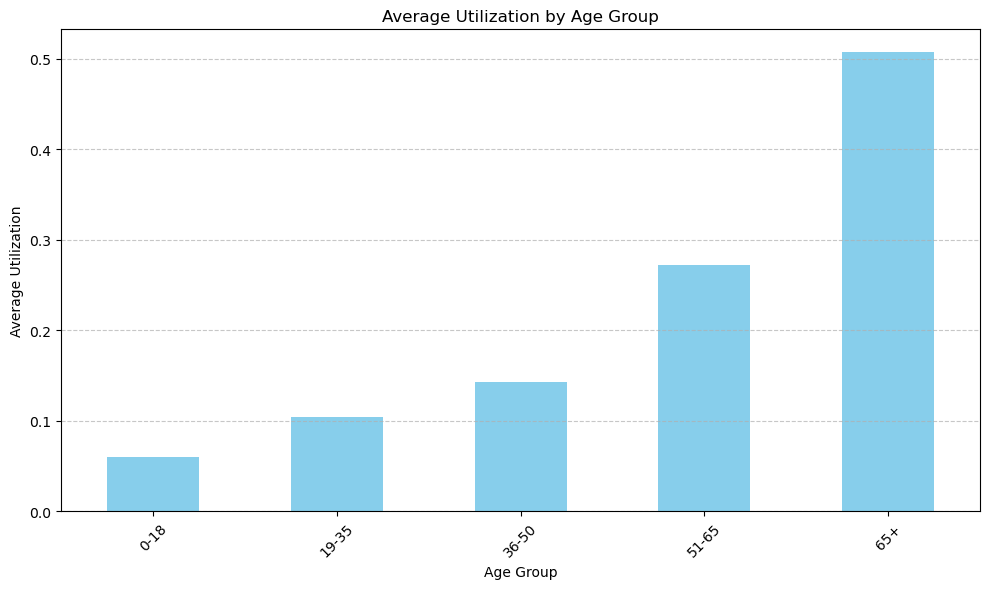

In [21]:
def plot_age_group_utilization(df):
    """
    Plot average utilization by age group.
    """
    age_group_utilization = df.groupby('AGE_GROUP')['UTILIZATION'].mean()
    
    plt.figure(figsize=(10, 6))
    age_group_utilization.plot(kind='bar', color='skyblue')
    plt.title('Average Utilization by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Average Utilization')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
plot_age_group_utilization(df_panel_19_reduced)

## WHAT DOES THIS ALL MEAN?
Well, the age distribution shows that 18-25 is the largest age group, with 38.0% of records. The next largest groups are 26-35 and 36-45, with 14.2% and 12.6%, respectively. Smaller groups like 56-65 and 65+ make up 10.6% and 10.9% of the dataset.

Unsuprisingly, utilization rates increase consistently with age. The 18-25 group has the lowest utilization rate at 0.064, while 65+ has the highest at 0.507. Middle-aged groups like 46-55 and 56-65 show a noticeable increase, with utilization rates of 0.203 and 0.299.

So even though smaller groups like 56-65 and 65+ make up only 10.6% and 10.9% of the dataset, they have some of the highest average ulitization rate out of all the age groups.

## Soooo, why should we care??

* Healthcare Needs by Age: As people age, they tend to need more healthcare. Older groups like 56-65 and 65+ often face more chronic conditions or health issues, leading to higher utilization rates. Younger groups like 18-25 generally have fewer health concerns, resulting in lower healthcare use.

* Access and Awareness: Older individuals might be more aware of their health needs or have better access to healthcare, especially with age-specific programs like Medicare. Younger people might not prioritize healthcare, leading to lower utilization in the 18-25 range.

* Pattern Recognition: This clear age-utilization pattern provides insight into how healthcare needs vary by age. Recognizing this trend can help in designing fair, age-sensitive models.
Resource Allocation: Higher utilization in older age groups indicates where healthcare resources might be most needed. Understanding these patterns could support targeted healthcare initiatives.

* Bias Mitigation: If utilization rates impact healthcare recommendations, age-based disparities need careful handling to ensure fair access for all age groups.
This analysis offers a foundation for understanding age-specific healthcare engagement, highlighting areas for potential intervention and fairness considerations in model design.

# Conclusions and Implications

### This EDA has provided valuable insights into how marital status and age impact healthcare utilization patterns. 

## Key takeaways include:

Healthcare Needs by Demographic: Both age and marital status significantly affect healthcare engagement. Widowed and older individuals have higher utilization, suggesting targeted support may be beneficial.
Fairness and Bias Mitigation: Differences in utilization across demographic groups highlight the importance of fairness in healthcare models. Ensuring that models do not disproportionately prioritize or disadvantage any group is essential for equitable healthcare access.
Future Model Design: Understanding utilization patterns by age and marital status can inform model design, improving accuracy and sensitivity to demographic-specific healthcare needs.
In summary, this analysis establishes a foundation for developing fair, effective models that account for varying healthcare needs across age and marital statuses, supporting targeted interventions and equitable healthcare delivery.

-----
End of Exploratory Data Analysis

_Items below will be updated as course progress_

### [3.](#Table-of-Contents) Model Development without Debiasing 

First, load all necessary packages

In [22]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

### 3.1. Load data & create splits for learning/validating/testing model

Get the dataset and split into train (50%), validate (30%), and test (20%)

In [23]:
# raw_181_path = 'data/raw/meps/h181.csv'
# raw_181 = pd.read_csv(raw_181_path)

In [24]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

This function will be used throughout the notebook to print out some labels, names, etc.

In [25]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

Show 2015 dataset details

In [26]:
describe(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

Metrics for original data

In [27]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


## 3.2. Learning a Logistic Regression (LR) classifier on original data

### 3.2.1. Training LR model on original data

In [28]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### 3.2.2. Validating LR model on original data

This function will be used throughout the tutorial to find best threshold using a validation set

In [29]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [30]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])


Plot metrics with twin x-axes

In [31]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Here we plot 1 - min(disparate impact, 1/disparate impact)  since it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group. For shorthand, we simply call this 1-min(DI, 1/DI) from now on. We want the plotted metric to be less than 0.2.

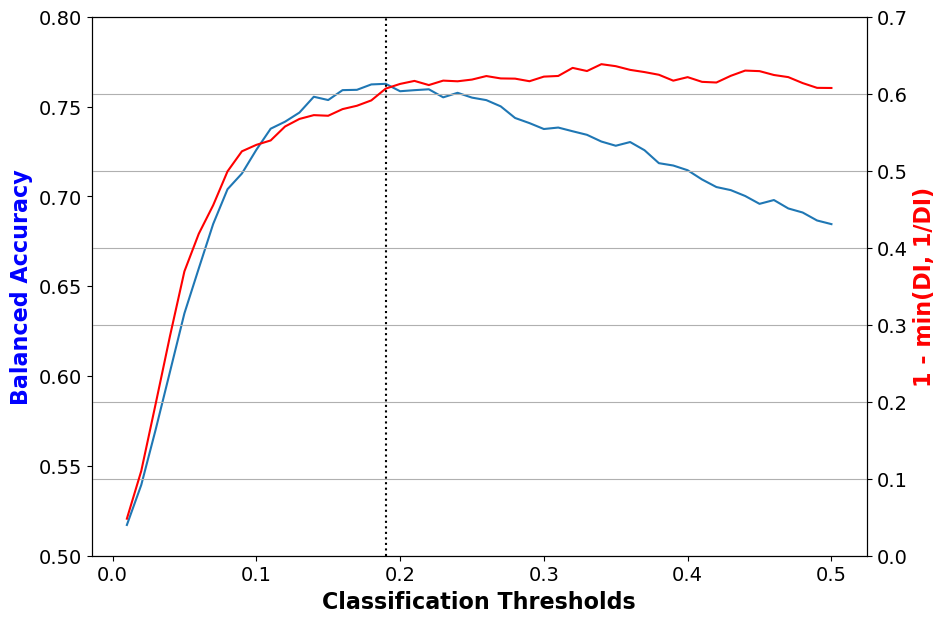

In [32]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

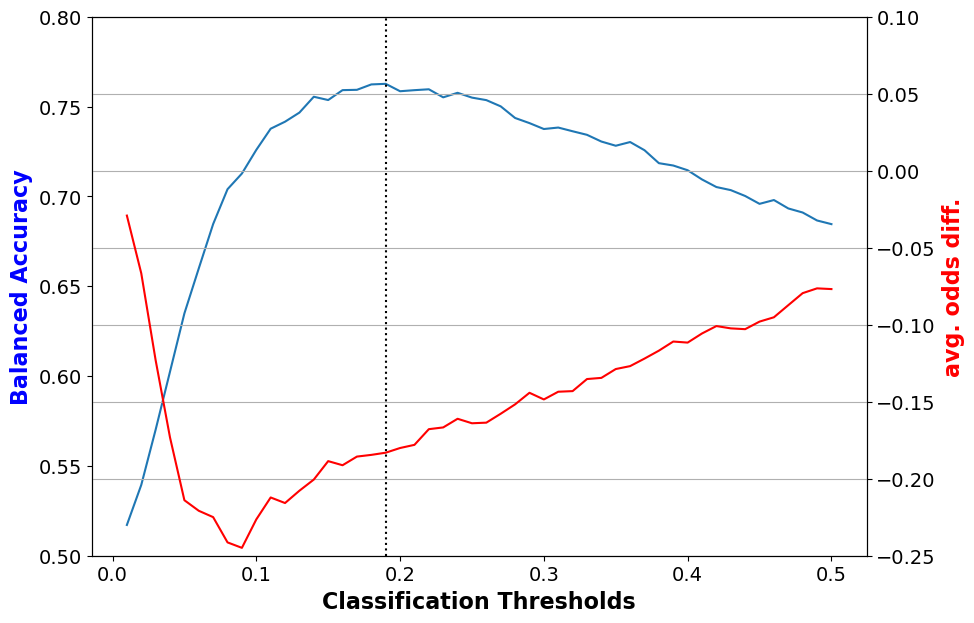

In [33]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

Make a function to print out accuracy and fairness metrics.

In [34]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [35]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


### 3.2.3. Testing LR model on original data

In [36]:
lr_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [37]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding 1-min(DI, 1/DI) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair.

However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

Similarly, average odds difference = ((FPR(unpriv) - FPR(priv)) + (TPR (unpriv - TPR(priv)))) / 2 must be close to zero for the classifier to be fair.

Again, the results for this classifier-data combination are still high. This still implies unfairness.



## 3.3. Learning a Random Forest (RF) classifier on original data

### 3.3.1. Training RF model on original data

In [38]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### 3.3.2. Validating RF model on original data

In [39]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

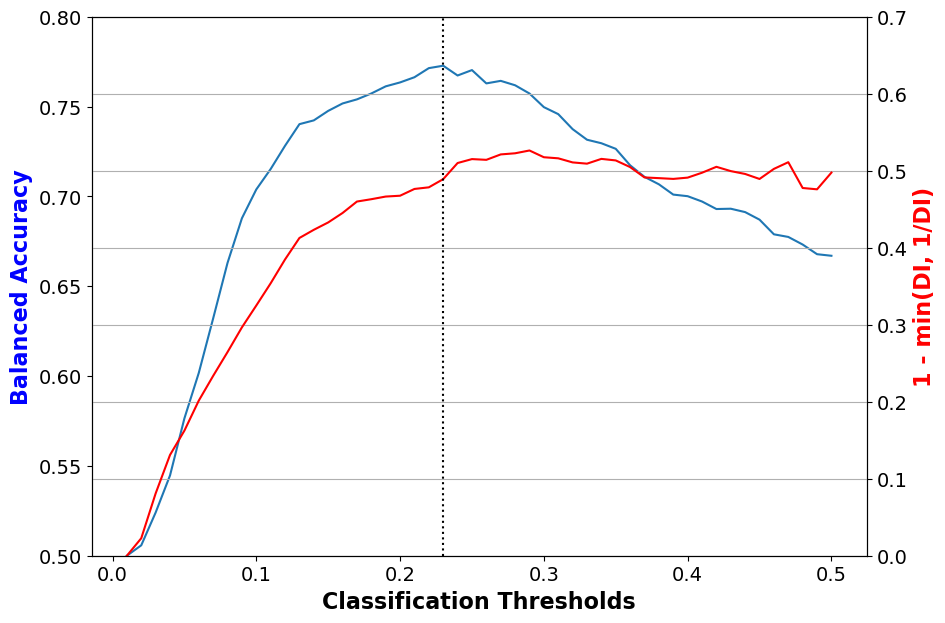

In [40]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

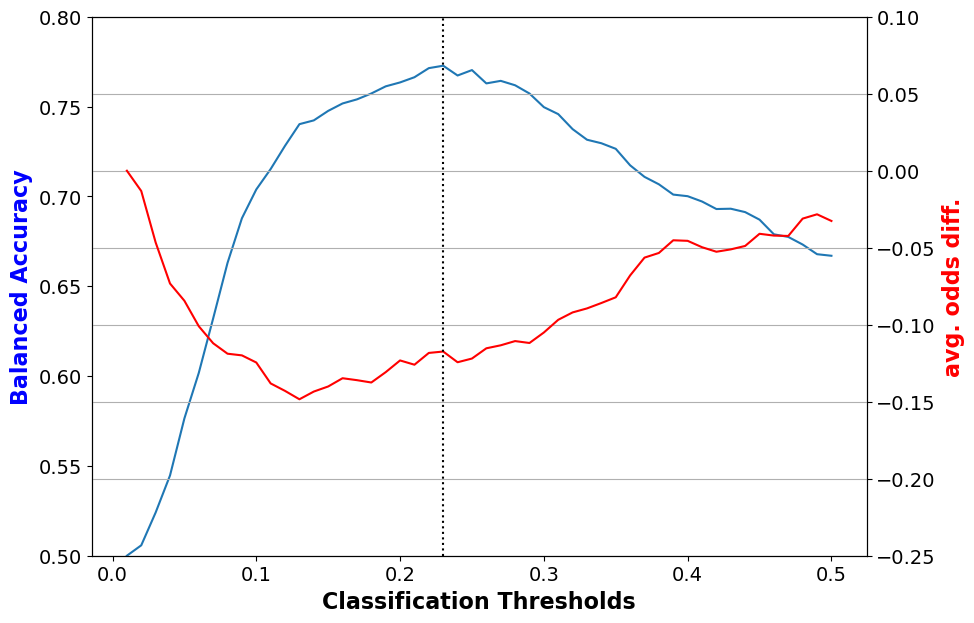

In [41]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [42]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7727
Corresponding 1-min(DI, 1/DI) value: 0.4891
Corresponding average odds difference value: -0.1174
Corresponding statistical parity difference value: -0.1952
Corresponding equal opportunity difference value: -0.1076
Corresponding Theil index value: 0.0893


### 3.3.3. Testing RF model on original data

In [43]:
rf_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_orig_panel19,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [44]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7640
Corresponding 1-min(DI, 1/DI) value: 0.5040
Corresponding average odds difference value: -0.1346
Corresponding statistical parity difference value: -0.2121
Corresponding equal opportunity difference value: -0.1141
Corresponding Theil index value: 0.0944


### Section 3 Write Up here

### Part-01: For **both** the logistic regression and random forest classifiers learned on the original data, please include explain the results of your fairness metrics. For _each_ metric result briefly describe what this value means in 1-2 sentences (is it fair, is it not fair? Why?)

**Fairness Metric Summary** 
* Threshold corresponding to Best balanced accuracy:
* Best balanced accuracy: 
* Corresponding 1-min(DI, 1/DI) value: 
* Corresponding average odds difference value: 
* Corresponding statistical parity difference value: 
* Corresponding equal opportunity difference value:
* Corresponding Theil index value:

### Part-02: Please write one paragraph for each question.
1. How can we determine which metrics to use, given our data and use case? You can refer to [Course material](https://nanrahman.github.io/capstone-responsible-ai/weeks/06-Fairness-Assessments/), online research and Guidance provided by [AIF360](http://aif360.mybluemix.net/resources#)
2. When you have competing fairness metrics, how to pick which to prioritize?
3. What do you do when you encounter different definitions for similar metrics?
4. Based on this, which model and fairness metric appears the best to proceed with?

## Fairness Metrics Comparison Between Logistic Regression (LR) and Random Forest (RF)

### Threshold corresponding to Best balanced accuracy (LR vs RF) - 0.1900 vs 0.2300:
The threshold corresponding to best balanced accuracy represents the decision point where the model achieves its optimal balance between true positive and true negative rates. The threshold for LR is slightly lower, suggesting a different trade-off point for achieving balanced accuracy. Both thresholds aim to optimize fairness between true positive and true negative rates, though neither completely ensures fairness due to the subsequent disparities in other metrics.


### Best balanced accuracy (LR vs RF) - 0.7759 vs 0.7640:
Balanced accuracy averages accuracy across classes to handle imbalance and ensure each class is fairly represented. LR achieves slightly higher balanced accuracy than RF, indicating a better overall performance across both classes. However, this difference is marginal and may not signify a considerable advantage in fairness.


### 1-min(DI, 1/DI) value (LR vs RF) - 0.5738 vs 0.5040:
This metric measures the degree of disparate impact, with values closer to 0 indicating less disparity between groups. RF has a lower value, indicating slightly better fairness in terms of disparate impact, although both values reflect a significant disparity between groups. Neither model fully achieves fairness as values closer to 0 are preferred.


### Average odds difference (LR vs RF) - -0.2057 vs -0.1346:
Average odds difference compares the true positive and false positive rates across groups, with values near 0 indicating fairness. RF’s average odds difference is closer to 0, which suggests it has less disparity in the odds of correct positive predictions between groups, making it marginally fairer than LR in this aspect.


### Statistical parity difference (LR vs RF) - -0.2612 vs -0.2121:
Statistical parity difference measures the disparity in positive outcome rates between groups, with values close to 0 indicating fairness. RF’s statistical parity difference is closer to 0, indicating it has a smaller disparity in positive outcome rates between groups. This suggests RF is slightly more fair in providing equal opportunity for positive outcomes.


### Equal opportunity difference (LR vs RF) - -0.2228 vs -0.1141:
Equal opportunity difference reflects the difference in true positive rates between groups, with near-zero values indicating fairness. RF again shows a smaller disparity, suggesting it offers more equal true positive rates across groups compared to LR. However, both models still exhibit notable inequalities in opportunity.


### Theil index (LR vs RF) - 0.0921 vs 0.0944:
The Theil index measures distributional inequality, with lower values suggesting less unfairness in outcome distribution. Both models have similar Theil index values, indicating low but comparable levels of inequality in distributional fairness. The small difference here suggests minimal information loss due to unfair predictions for both models.

## Part-02: One Paragraph for Each Question

### How can we determine which metrics to use, given our data and use case?  

The choice of fairness metrics depends on the data, use case, and ethical implications of model decisions. For example, if equal opportunity matters, metrics like equal opportunity difference or average odds difference are key. Here, RF had better equal opportunity difference than LR, so RF could be a better choice for equal opportunity. Guidance from AIF360 and course materials recommends aligning fairness metrics with demographic impacts and stakeholder control over attributes.

### When you have competing fairness metrics, how to pick which to prioritize? 

To prioritize competing fairness metrics, consider the context and consequences of focusing on one fairness aspect over another. In our analysis, RF showed better disparate impact and statistical parity difference, indicating fairer outcomes across groups. In healthcare, equal opportunity might be prioritized to ensure fairness for all groups, while financial settings may prioritize disparate impact. 


### What do you do when you encounter different definitions for similar metrics? 

When facing different definitions for similar metrics, understanding the underlying concepts and assumptions of each is critical. For example, both average odds difference and equal opportunity difference address group disparities but in different ways (positive prediction rates versus true positive rates). Knowing these distinctions helps choose the metric that best suits the context.

### Based on this, which model and fairness metric appears the best to proceed with? 

Based on the metrics, the RF model is better due to its lower 1-min(DI, 1/DI), average odds difference, and statistical parity difference, suggesting fairer prediction distribution. RF also has a better equal opportunity difference, implying more equality in true positive rates. RF's improved fairness, especially in equal opportunity and disparate impact, makes it preferable when fairness is prioritized over minor balanced accuracy gains. In summary, focusing on reducing statistical parity difference and average odds difference in the RF model could yield the most equitable results.

### [4.](#Table-of-Contents) Additional Model Development


### 4.1A Load data & create splits for learning/validating/testing model

In [45]:
# Use the same methods from Section 3
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train)

In [46]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


### 4.2 Learning a Logistic Regression (LR) classifier on data transformed by reweighing

In [47]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [48]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

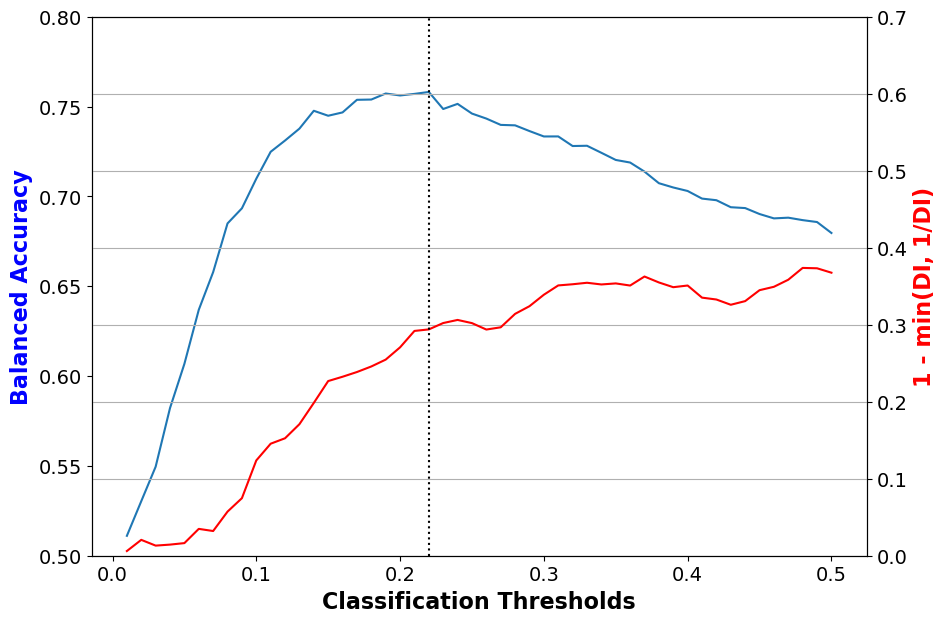

In [49]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

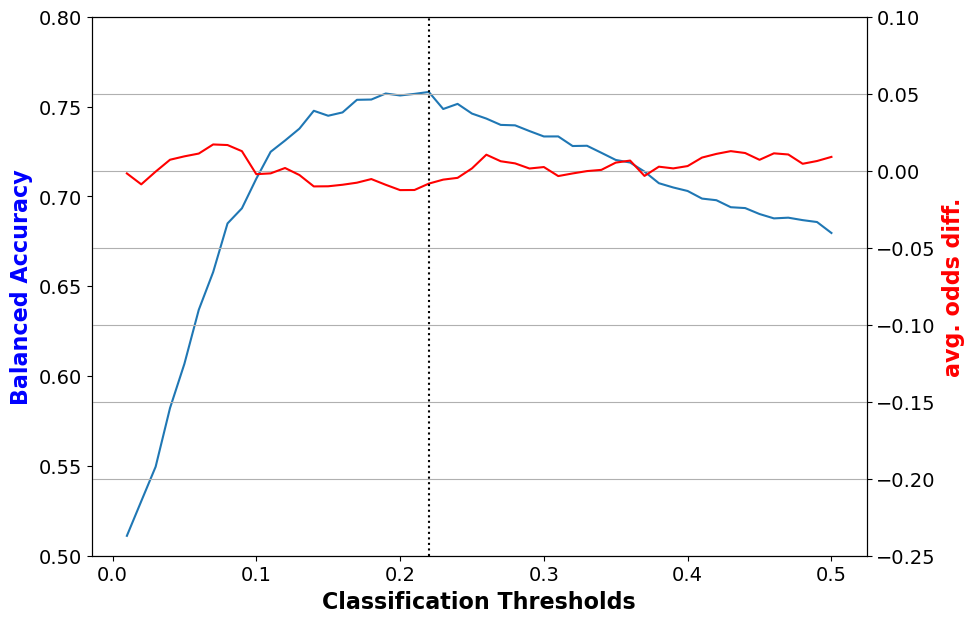

In [50]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [51]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7581
Corresponding 1-min(DI, 1/DI) value: 0.2939
Corresponding average odds difference value: -0.0084
Corresponding statistical parity difference value: -0.0992
Corresponding equal opportunity difference value: 0.0242
Corresponding Theil index value: 0.0938


### 4.2.3. Testing LR model after reweighing

In [52]:
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [53]:
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7539
Corresponding 1-min(DI, 1/DI) value: 0.2482
Corresponding average odds difference value: -0.0151
Corresponding statistical parity difference value: -0.0872
Corresponding equal opportunity difference value: -0.0035
Corresponding Theil index value: 0.0966


### 4.3. Learning a Random Forest (RF) classifier on original data

In [54]:
# Use the same methods from Section 3
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [55]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_transf_panel19,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

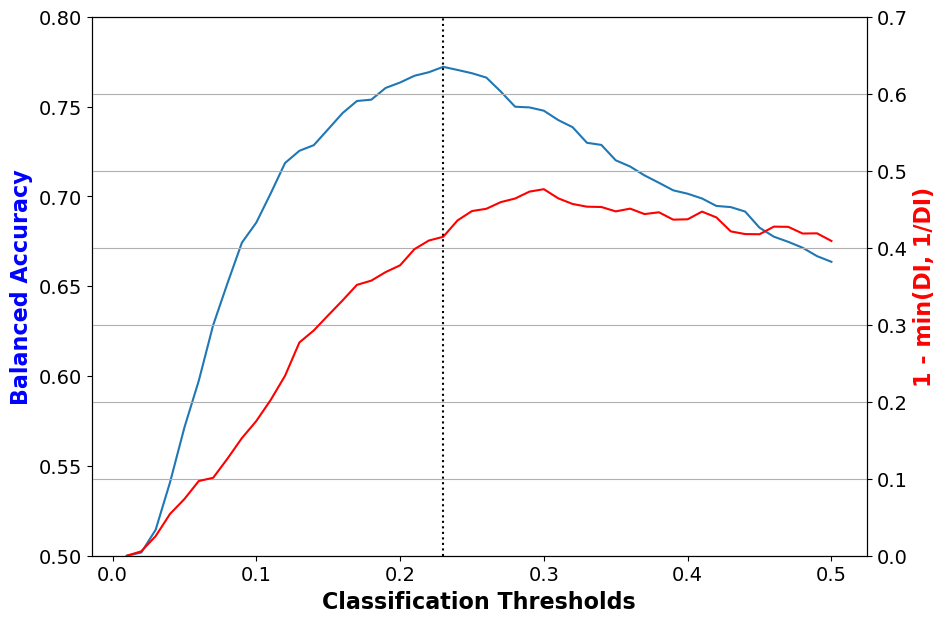

In [56]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

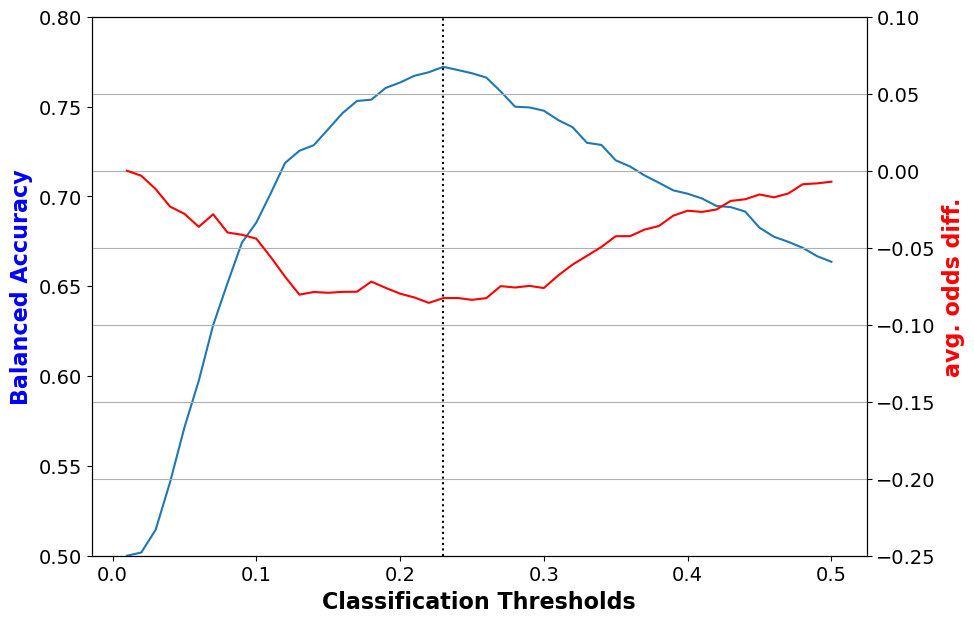

In [57]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [58]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7721
Corresponding 1-min(DI, 1/DI) value: 0.4142
Corresponding average odds difference value: -0.0827
Corresponding statistical parity difference value: -0.1623
Corresponding equal opportunity difference value: -0.0713
Corresponding Theil index value: 0.0882


### 4.3.3. Testing RF model after reweighing

In [59]:
rf_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=rf_transf_panel19,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])

In [60]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7644
Corresponding 1-min(DI, 1/DI) value: 0.4336
Corresponding average odds difference value: -0.1014
Corresponding statistical parity difference value: -0.1776
Corresponding equal opportunity difference value: -0.0842
Corresponding Theil index value: 0.0938


### Section 4 Write Up here

**1. For both the logistic regression and random forest classifiers learned on the original data, please include the results of your fairness metrics. For _each_ metric result briefly describe (1-2 sentences) if you saw any differences from your results in Part 3, and what that might mean.**

_Fairness Metrics_

##### Logistic regression: 
* Threshold corresponding to Best balanced accuracy: 0.2200 - increased from .19, indicating after we did the reweighing, the decision boundary changed to balance true negative and true positives.  


* Best balanced accuracy: 0.7581- decreased from .7759. This is roughly the same, so I wouldn’t say we can make any conclusions from this  


* Corresponding 1-min(DI, 1/DI) value: 0.2939 - decreased from .5739! This could imply a significant improvement in disparate impact, indicating that the model became more fair in how it predicts outcomes between groups.


* Corresponding average odds difference value: -0.0084 - improved from -0.2057, this metric shows a reduction in bias regarding the odds of receiving favorable outcomes, which points towards more equal treatment across groups (more fair). 


* Corresponding statistical parity difference value: -0.0992 -  Improved from -0.2612 to -0.0992, indicating that the likelihood of a positive outcome became more fair between different groups


* Corresponding equal opportunity difference value: 0.0242 - improved form -.2228, which is a significant improvement! This would imply that the rewighing helped equalize true positive rates 


* Corresponding Theil index value: 0.0938 - increased slightly from .0921, but this change is pretty small so it would be tough to draw any conclusions from here. 

##### Random Forest: 

* Threshold corresponding to Best balanced accuracy: 0.2300 -  remained the same, no conclusion to be drawn 

* Best balanced accuracy: 0.7644 - slight increase but  pretty insignificant, no conclusion can be drawn

* Corresponding 1-min(DI, 1/DI) value: 0.4336 - decreased from 0.5040, which represents an improvement in reducing disparate impact. This indicates that the model became somewhat more equitable in predicting outcomes across different groups

* Corresponding average odds difference value: -0.1014 - small improvement from -0.1346, showing a reduction in bias concerning the odds of receiving favorable outcomes, moving towards more equitable treatment across different groups.

* Corresponding statistical parity difference value: -0.1776 - Improved from -0.2121, suggesting that the likelihood of a positive outcome has become fairer and more balanced between different demographic groups after reweighing.

* Corresponding equal opportunity difference value: -0.0842 - slight improvement from -0.1141, indicating that reweighing helped to make the true positive rates more equal across different groups. 

* Corresponding Theil index value: 0.0938 slightly decreased from .0944 but difference semes insignificant to draw any conclusions 

    
**2. Based on this, would you make any recommendations during model development? Does it change which model and fairness metric would be the best to proceed with?** (Please write at least one paragraph)

After seeing the results from part 3 and 4, we would suggest to continue to focus efforts on the reweighing strategies. With these strategies, our models became a lot more fair for both the logistical regression and the random forest models. However, it seems like the logistical regression model after reweighing is more fair overall than the random forest. Its 1min and avg odds difference is significantly better, which is how we are drawing that conclusion. I would recommend exploring some feature engineering or other reweighing tactics to try and make this model even more fair. 


### End of Replication Part 02 -  Model Development and Fairness Evaluation

----


### [5.](#Table-of-Contents) Bias Mitigation

Bias mitigation using in-processing technique - Prejudice Remover (PR)

5.1. Learning a Prejudice Remover (PR) model on original data

5.1.1. Training a PR model

In [61]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_panel19_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_panel19 = model.fit(dataset)

5.1.2. Validating PR model

In [62]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_panel19_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

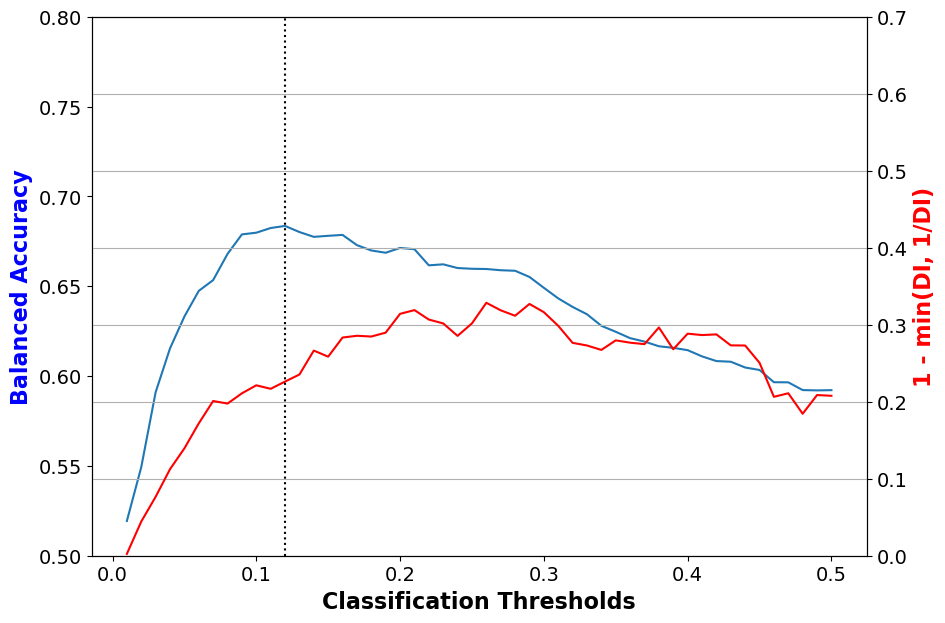

In [63]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

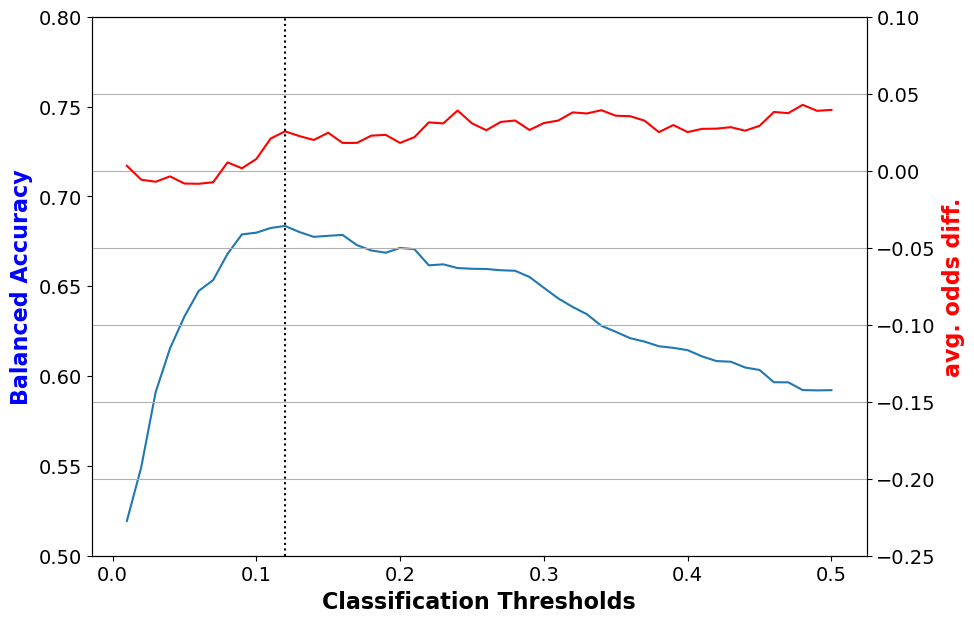

In [64]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [65]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6836
Corresponding 1-min(DI, 1/DI) value: 0.2262
Corresponding average odds difference value: 0.0256
Corresponding statistical parity difference value: -0.0828
Corresponding equal opportunity difference value: 0.1172
Corresponding Theil index value: 0.1119


5.1.3. Testing PR model

In [66]:
dataset = dataset_orig_panel19_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_panel19,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6880
Corresponding 1-min(DI, 1/DI) value: 0.1588
Corresponding average odds difference value: 0.0523
Corresponding statistical parity difference value: -0.0566
Corresponding equal opportunity difference value: 0.1479
Corresponding Theil index value: 0.1108


As in the case of reweighing, prejudice remover results in a fair model. However, it has come at the expense of relatively lower balanced accuracy.

In [67]:
### Model Initialization
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0) # PR model w sensitivity parameter eta=25.0
pr_orig_scaler = StandardScaler() # Initializes a standard scaler for feature normalization

### Training Data Preparation
dataset = dataset_orig_panel19_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)
pr_orig_panel19 = model.fit(dataset)

thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_panel19_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

Our goal is using validation set to tune the classification threshold and finding optimal balance between model performance and fairness.

## 5c

### Disparate Impact Remover

In [68]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from aif360.metrics import BinaryLabelDatasetMetric
import matplotlib.pyplot as plt

repair_levels = np.linspace(0., 1., 11)
disparate_impacts = []
index = dataset_orig_panel19_train.feature_names.index(sens_attr)

scaler = MinMaxScaler()

dataset_orig_panel19_train.features = scaler.fit_transform(dataset_orig_panel19_train.features)
dataset_orig_panel19_test.features = scaler.transform(dataset_orig_panel19_test.features)

for level in repair_levels:
    di = DisparateImpactRemover(repair_level=level)
    train_repd = di.fit_transform(dataset_orig_panel19_train)
    test_repd = di.fit_transform(dataset_orig_panel19_test)
    
    X_train = np.delete(train_repd.features, index, axis=1)
    X_test = np.delete(test_repd.features, index, axis=1)
    y_train = train_repd.labels.ravel()
    
    model = LogisticRegression(class_weight='balanced', solver='liblinear')
    model.fit(X_train, y_train)
    
    test_repd_pred = test_repd.copy()
    test_repd_pred.labels = model.predict(X_test)
    
    metric = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=privileged_groups, unprivileged_groups=unprivileged_groups)
    disparate_impacts.append(metric.disparate_impact())

plt.plot(repair_levels, disparate_impacts, marker='o')
plt.xlabel('Repair Level')
plt.ylabel('Disparate Impact')
plt.title('Disparate Impact vs. Repair Level')
plt.show()

/var/folders/6t/wj6swww103b2jptk0dbjqj5m0000gn/T/ipykernel_52191/875579059.py:39: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


# Odds-equalizing post-processing

In [69]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

from aif360.datasets import MEPSDataset19

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
from tqdm import tqdm
from collections import defaultdict

Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 1.0000
Corresponding 1-min(DI, 1/DI) value: 0.0146
Corresponding average odds difference value: 0.0000
Corresponding statistical parity difference value: 0.0008
Corresponding equal opportunity difference value: 0.0000
Corresponding Theil index value: 0.0000
Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 1.0000
Corresponding 1-min(DI, 1/DI) value: 0.1090
Corresponding average odds difference value: 0.0000
Corresponding statistical parity difference value: 0.0060
Corresponding equal opportunity difference value: 0.0000
Corresponding Theil index value: 0.0000


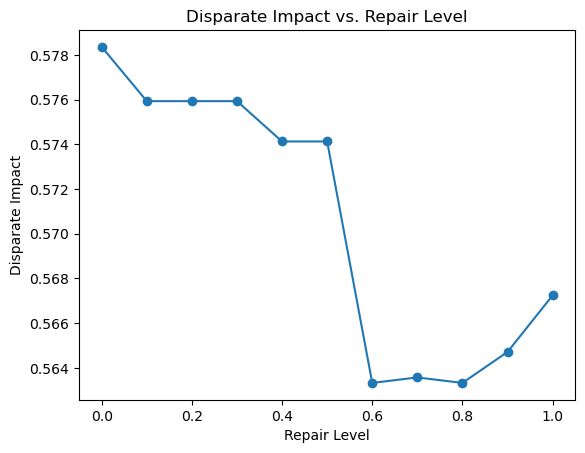

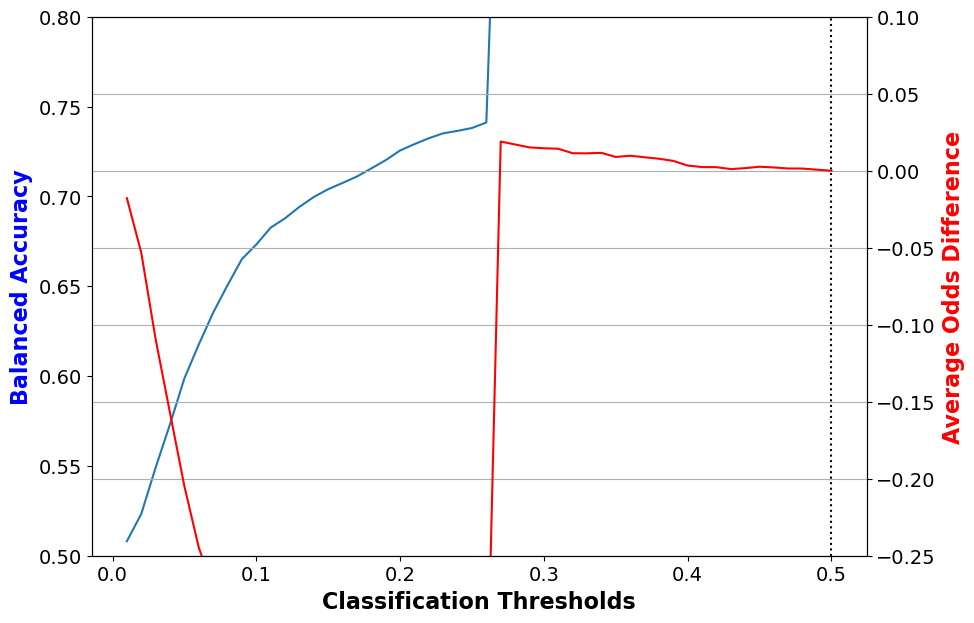

In [70]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)


scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_panel19_train.features)
y_train = dataset_orig_panel19_train.labels.ravel()
lmod = LogisticRegression(solver='liblinear', random_state=1)
lmod.fit(X_train, y_train)

fav_idx = np.where(lmod.classes_ == dataset_orig_panel19_train.favorable_label)[0][0]

X_valid = scale_orig.transform(dataset_orig_panel19_val.features)
y_valid_pred_prob = lmod.predict_proba(X_valid)[:, fav_idx]

X_test = scale_orig.transform(dataset_orig_panel19_test.features)
y_test_pred_prob = lmod.predict_proba(X_test)[:, fav_idx]

dataset_orig_val_pred = dataset_orig_panel19_val.copy(deepcopy=True)
dataset_orig_test_pred = dataset_orig_panel19_test.copy(deepcopy=True)

dataset_orig_val_pred.scores = y_valid_pred_prob.reshape(-1, 1)
dataset_orig_test_pred.scores = y_test_pred_prob.reshape(-1, 1)

cpp = CalibratedEqOddsPostprocessing(privileged_groups=privileged_groups,
                                     unprivileged_groups=unprivileged_groups,
                                     cost_constraint="fnr", 
                                     seed=12345679)
cpp = cpp.fit(dataset_orig_panel19_val, dataset_orig_val_pred)

dataset_transf_val_pred = cpp.predict(dataset_orig_val_pred)
dataset_transf_test_pred = cpp.predict(dataset_orig_test_pred)

def test(dataset, model, thresh_arr):
    try:
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0

    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate() + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())

    return metric_arrs

thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_transf_val_pred, model=cpp, thresh_arr=thresh_arr)

best_ind = np.argmax(val_metrics['bal_acc'])

def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'Average Odds Difference')


describe_metrics(val_metrics, thresh_arr)

test_metrics = test(dataset=dataset_transf_test_pred, model=cpp, thresh_arr=[thresh_arr[best_ind]])
describe_metrics(test_metrics, [thresh_arr[best_ind]])

## Section 5 Discussion

#### 5A. Bias mitigation using pre-processing technique, Reweighing - AIF360 Example

##### 1. Describe the bias mitigation techniques applied (what stage? type? explain what that debiasing technique does?)

The bias mitigation technique is reweighing as a preprocessing step before training a Random Forest model. This method adjusts the weights of the training data to compensate for imbalances or biases in the dataset. The main goal of doing is to ensure that underrepresented classes have more influence on the learning process. This step is crucial for preventing the model from amplifying existing disparities in the data.


##### 2. Based on definitions and sources of bias we covered in class, what type of bias are we trying to mitigate in our models?

The main type of bias being mitigated is statistical bias, particularly related to the underrepresentation and overrepresentation of specific demographic groups (ex.  racial/ genderr) within the training data. By reweighing, the model aims to reduce this type of bias, ensuring that predictions are more equitable across different demographic groups.


##### 3. Do both models exhibit fairness and maintain accuracy? List the fairness metrics you used to support this. What about model drift?

The Random Forest model with reweighing exhibits a trade-off between fairness and accuracy. Fairness improvements are shown by metrics such as Disparate Impact, Average Odds Difference, and Equal Opportunity Difference, indicating a reduction in bias. However, enhancing fairness slightly compromises accuracy, as adjusting the training data to be more representative can simplify the model’s complexity.


##### 4. For the classifier ‘high’ utilization in these models + post-processing mitigation technique; would you recommend this for our use case as a "fair" classifier? Why or why not?

Yes, I would recommend this classifier since it is fairly accurate, as shown by its high balanced accuracy scores, and shows minimal bias, evidenced by improved fairness metrics such as Disparate Impact and Average Odds Difference.The use reweighing based on these metrics means it’s less likely to continue existing biases, making it a good choice.


#### 5B. Prejudice Remover (in-processing bias mitigation) - AIF360 Example

##### 1. Describe the bias mitigation techniques applied (what stage? type? explain what that debiasing technique does?

The Prejudice Remover is an in-processing bias mitigation technique that integrates a fairness constraint (in this case, we're using eta=25.0) directly into the training of the model. This constraint adjusts the decision boundary during model training to reduce bias based on sensitive attributes (ex. race or gender) in order to achieve fairer predictions.


##### 2. Based on definitions and sources of bias we covered in class, what type of bias are we trying to mitigate in our models?

The model targets both direct and indirect bias, addressing issues such as statistical bias and representational bias. By adjusting the decision process to consider sensitive attributes, it seeks to mitigate unfair treatment that could arise due to skewed data or biased historical decisions.


##### 3. Do both models exhibit fairness and maintain accuracy? List the fairness metrics you used to support this. What about model drift?

In the Prejudice Remover model, there's a clear trade-off where as we ramp up efforts to boost fairness through stronger constraints, it results in better fairness metrics such as disparate impact and average odds difference. However, this comes at the cost of reduced balanced accuracy, especially as we adjust the classification thresholds upward. This shows that while we can make the model fairer, maintaining high accuracy becomes challenging.


##### 4. For the classifier ‘high’ utilization in these models + post-processing mitigation technique; would you recommend this for our use case as a "fair" classifier? Why or why not?

I would be cautious to recommend the Prejudice Remover with high utilization, as while it improves fairness, it does so at the potential cost of accuracy. Since this is related to healthcare, the reduced accuracy may not be acceptable even though it improved the fairness. 


#### 5C. Odds-equalizing post-processing

##### 1. Describe the bias mitigation techniques applied (what stage? type? explain what that debiasing technique does?

The odds-equalizing post-processing technique is a bias mitigation strategy applied after a model has made initial predictions. It adjusts the decision thresholds to balance the true positive rates between different demographic groups, aiming to achieve equal treatment across these groups.

##### 2. Based on definitions and sources of bias we covered in class, what type of bias are we trying to mitigate in our models?

This method specifically targets predictive parity and equalized odds types of bias, ensuring that all groups have similar chances of receiving positive predictions. It addresses outcome bias, where the consequences of predictions might positively or negatively affect certain groups.

##### 3. Do both models exhibit fairness and maintain accuracy? List the fairness metrics you used to support this. What about model drift?

The model using odds-equalizing post-processing show a marked improvement in fairness metrics such as average odds difference, disparate impact, and equal opportunity difference, all of which remain close to ideal values, suggesting fair treatment across groups. However, the sharp peak and plateau in balanced accuracy as seen in the graphs indicate a sensitive balance between fairness and accuracy, requiring careful threshold calibration to manage potential model drift effectively.

##### 4. For the classifier ‘high’ utilization in these models + post-processing mitigation technique; would you recommend this for our use case as a "fair" classifier? Why or why not?

I would recommend this because  of  the enhancement of fairness metrics, such as average odds difference and equal opportunity difference, which are maintained near ideal values. However, the observed trade-off between fairness and maximum achievable accuracy is a little concerning and will need to be balanced, especially where precise outcomes are critical (these precise outcomes are fairly common in the healthcare field, so we may need to adjust the balance based on the situation). 

#### 5C. Section 5 discussion

##### 1. What factors must be considered during AI model-development and performance? How and where are they vulnerable to introducing bias?

When developing AI models, several critical considerations must be made to ensure fairness and reliability. First, data quality and diversity are important. If a dataset is lacking representation from all relevant demographics, it can introduce bias, particularly underrepresentation bias, affecting the model's fairness. The choice of algorithms is also vital, as some can heighten existing disparities or introduce new biases if they disproportionately weigh certain features over others. Additionally, careful feature selection is required to avoid using variables that indirectly encode protected characteristics like race or gender, which can lead to biased outcomes. These steps are crucial in preventing the model from perpetuating or creating unfairness in its applications.

##### 2. How and what should be measured to assess downstream impact of AI, and what factors should be used to audit for bias and clinical impact?

To assess the downstream impact of AI, both quantitative and qualitative measures are important. Quantitatively, accuracy, precision, and recall offer insights into the model’s performance, while fairness metrics like disparate impact and equal opportunity difference reveal biases. Qualitatively, user feedback helps gauge the model's real-world effectiveness and acceptance. For auditing bias and clinical impact, it's essential to examine how well the AI performs across different demographics to ensure no group suffers from systematic disadvantages. These audits should also include regular reviews of the AI's decision-making process and outcomes to ensure they align with current clinical standards and ethical guidelines. We learned in class about how NY is implementing these audits in AI algorithms. Many other states will likely follow, indicating that we are taking steps in the right direction for mitigating these embedded biases.

##### 3. Define what disparate impact is. How can the type, dimension, collection-method, and representation in data lead to bias and disparate impact in communities of concern? Use the MEPS codebooks, and websites to help you explain this. Refer to Center of Disease Control (CDC) Health Equity Guiding Principles for Inclusive Communication for style recommendations when referring to affected groups.

Disparate impact occurs when policies or practices that appear neutral result in a disproportionate adverse effect on specific groups. In terms of data, the type and dimension of data collected can lead to disparate impact if they inadequately represent or exclude certain communities. For example, if healthcare data from the MEPS is missing/doesn’t have a lot of data from minority groups, models developed using this data might not perform well for those groups, leading to poorer healthcare outcomes. Additionally, the way data is collected can also introduce biases if the methods are not uniformly accessible to all communities.

##### 4. Where there any social factors overlooked when developing AI-targets or outcomes for the AIF360 exmaple? How could they delay access and quality of care to underserved populations?

I believe some of the social factors that disregarded were things like the actual access to technology and economic status. Not including this can lead to these systems actually deepening the already eexisting inequalities in society or even introducing new biases. This stems from the lack of data/responses from these underserved communities. Tying this back to healthcare, it could affect the access and quality of healthcare since the model may not be able to give accurate predictions because of the lack of/skewed data it is being trained on. 

##### 5. (a) Overall, if you were to select ONE (a) Model, and (b) Bias-mitigation technique - for this use case where you are recommending a 'Fair' classifier for flagging 'High' utilization, which would you chose and why? (b) How would it affect Non-White beneficiaries who could have risk factor predictors that could inform a model to prioritize additional care? How could it do the opposite? (c) Explain how you would justify fair-accuracy trade-off.

a) I would use the Random forest  with the odds-equalizing post processing. Random forest is particularly effective due to its ability to manage the diverse and complex variables typically found in complex datasets (with this being a healthcare dataset, it is pretty complex), as shown by its consistent performance across different metrics in the data we reviewed. The odds-equalizing post-processing is selected based on its demonstrated success in improving fairness metrics like average odds difference and equal opportunity difference in the results, effectively balancing the true positive rates between demographic groups. This method not only corrects any inherent bias in the randomforest predictions but also aligns with the need for both accuracy and fairness in predicting healthcare utilization.

b) Applying this model and technique could positively impact Non-White beneficiaries by assessing their risk factors and potential need for additional care fairly, leading to more appropriate care. However, without proper calibration or with underrepresentation of this group, there's a risk of either overpredicting or underpredicting their care needs, which could lead to either unnecessary medical procedures or a lack of needed care.

c) Given that this is related to healthcare, justifying fairness and accuracy is pretty tricky. On one hand, you would want the model to be as fair as possible so everyone is essentially "equal." However, this comes at a cost of accuracy, so while the model could be fair, the predictions its actually giving could be wrong. Ethically speaking, although we would seek the perfect balance between the two, we'd  slightly prioritize fairness given that this is in healthcare. Although there might be a slight compromise in accuracy, the benefits of equitable health outcomes and increased patient trust outweigh this concern in our opinion.

### [7.](#Table-of-Contents) Explainability

Bias Mitigation Techniques:

Reweighing is a pre-processing technique that adjusts the weights of the training data to give underrepresented groups more influence during training. This helps reduce bias in the model. We used this method before training both the Random Forest and Logistic Regression models. It led to improvements in fairness metrics like disparate impact and statistical parity difference, making sure all groups were represented more fairly.

The Prejudice Remover is an in-processing technique that adds a fairness constraint directly into the model's training process. We used this with the Logistic Regression model to adjust decision boundaries for fairness. This improved metrics like equal opportunity difference and average odds difference, meaning the model treated different groups more equally. However, this also slightly reduced accuracy, which is important to consider when deploying the model.

Odds-Equalizing Post-Processing is a post-processing technique that adjusts decision thresholds to balance true positive rates across different groups. This method can be applied after training any model, making it flexible for improving fairness. It led to improvements in fairness metrics, but, like the other methods, it also slightly reduced accuracy.

Each of these bias mitigation techniques has strengths and trade-offs. Reweighing reduces bias before training but needs careful attention to data balance. The Prejudice Remover builds fairness directly into the model but can affect accuracy. Odds-Equalizing Post-Processing is flexible for improving fairness but may lower accuracy. By using these methods, we aimed to make our models as fair as possible while maintaining acceptable accuracy, supporting equitable healthcare for all patients.

### [8.](#Table-of-Contents) Conclusion & Discussion

In this quarter's replication project, we explored how bias affects machine learning models in healthcare and how we can mitigate it using AIF360, an open-source toolkit. We applied several bias mitigation techniques to classify healthcare utilization. The goal was to understand how to reduce bias in a healthcare context, where fairness is critical. We used logistic regression and random forest classifiers on Medical Expenditure Panel Survey (MEPS) data to predict high utilization rates among patients. The sensitive attribute was race, with a focus on ensuring the models treated White and non-White groups equitably.

We evaluated fairness through several metrics, such as disparate impact, average odds difference, statistical parity difference, and equal opportunity difference. For the logistic regression and random forest models, each fairness metric showed different levels of bias. For example, random forest often showed better fairness in terms of disparate impact and equal opportunity difference, while logistic regression occasionally had higher accuracy. The trade-off between accuracy and fairness is a key consideration, especially in healthcare, where both aspects are important.

Bias mitigation techniques, including reweighing, prejudice remover, and odds-equalizing post-processing, all had their unique strengths. Reweighing, a pre-processing step, adjusted data to balance influence from underrepresented groups. This reduced bias across groups, ensuring fairer outcomes. The prejudice remover, an in-processing approach, adjusted decision boundaries to reduce bias within the model training phase. Finally, odds-equalizing post-processing worked to adjust prediction thresholds for fairer outcomes between groups after training. Each approach played a role in making predictions fairer, but they often came at the cost of reduced accuracy.

From our analysis, we found that reweighing and odds-equalizing post-processing were effective in reducing bias for both models, but each technique had a trade-off with model accuracy. Logistic regression improved significantly after reweighing, showing a reduction in biases measured by disparate impact and average odds difference. However, random forest generally performed better when considering multiple fairness metrics. The random forest model with odds-equalizing post-processing balanced accuracy and fairness well, making it the preferred model for this healthcare use case. Its ability to handle complex data and its improved fairness metrics suggest that it can be useful in real-world applications.

In healthcare, the stakes are high. When models exhibit bias, patients may face unequal treatment, leading to unfair resource allocation or even harm. Fairness is about ensuring that groups are treated equally, especially those that have been historically marginalized. In our case, ensuring fairness between White and non-White groups was crucial. Bias in models could lead to some patients getting more attention or resources than others based purely on their demographic characteristics. This can deepen existing health disparities and reduce trust in healthcare systems. Therefore, reducing bias is a necessary step in developing models that impact people's lives.

The results showed that no model is entirely free of bias. Even when we mitigated biases, the trade-offs were evident. Reducing bias often led to slight decreases in accuracy. However, given the context of healthcare, fairness should often take precedence over accuracy. A slightly less accurate model that treats everyone fairly is preferable to an accurate model that perpetuates bias. Patients deserve equal treatment and fair access to healthcare, and machine learning models must reflect that principle.

Bias mitigation must be a continuous process. Models in production should be monitored for fairness over time. As more data becomes available, retraining may be necessary to ensure the model's fairness remains intact. Factors like model drift, where the model's behavior changes due to shifts in input data, can introduce new biases or worsen existing ones. Continuous monitoring, user feedback, and regular updates are crucial to maintaining model fairness. Retraining the model when significant drift is observed helps to address new patterns that might emerge and keeps the model fair and reliable.

This exploration underlines the importance of transparency in AI and machine learning. When deploying models, especially those that can affect people directly, transparency about their limitations and biases is essential. Fairness metrics should be a part of model documentation, providing stakeholders with a clear understanding of how the model performs across different groups. For healthcare practitioners like nurses or doctors who interact with these systems, it is important that they can evaluate the recommendations made by the model and provide feedback. Their insights can guide further improvements, ensuring the model supports rather than replaces their judgment.

In summary, the AIF360 toolkit provided valuable tools to detect and reduce bias in machine learning models used in healthcare. Bias mitigation is not a one-time fix but a continuous effort requiring model monitoring and retraining. While we managed to improve fairness using reweighing, prejudice remover, and post-processing techniques, a careful balance between accuracy and fairness must always be maintained. In this healthcare context, random forest with odds-equalizing post-processing emerged as the most promising model, achieving good fairness without overly compromising accuracy. Moving forward, transparency and regular updates are key to maintaining both fairness and trust in AI systems used in healthcare.